#LDA bigrams nouns only model

# Tagging the nouns in the text

In [3]:
# dataset for the unigrams nouns only
bi_nouns = df

# Create an empty list to store the processed texts
processed_texts = []

# Process the text for each row
for row in bi_nouns['cleanned_text']:
    # Convert the list of words to a string
    text = ' '.join(row)

    # Process the text
    doc = nlp(text)

    # Append the processed text to the list
    processed_texts.append(doc)

# Create 'tagged' column with POS tags
bi_nouns['tagged'] = processed_texts

# Check if tagged word is a noun and create 'noun' column
bi_nouns['noun'] = bi_nouns['tagged'].apply(lambda x: [word.text for word in x if word.pos_ in ['NOUN', 'PROPN']])

# Print the DataFrame
bi_nouns .head(5)

,Vraag,Antwoord,lemmatized_words,cleanned_text,tagged,noun
0,Zijn er andere thema's en onderwerpen waarover...,"Nee, informatievoorziening prima op orde","[Nee, ,, informatievoorziening, prima, op, orde]","[informatievoorziening, prima, orde]","(informatievoorziening, prima, orde)","[informatievoorziening, orde]"
1,Zijn er andere thema's en onderwerpen waarover...,Neen,[Neen],[],(),[]
2,Zijn er andere thema's en onderwerpen waarover...,Aanbestedingen en onderhoudscontracten. Het pe...,"[Aanbestedingen, en, onderhoudscontracten, ., ...","[aanbestedingen, onderhoudscontracten, persone...","(aanbestedingen, onderhoudscontracten, persone...","[aanbestedingen, personeel, communicatie]"
3,Zijn er andere thema's en onderwerpen waarover...,geen andere them's,"[geen, andere, them, 's]",[them],(them),[them]
4,Zijn er andere thema's en onderwerpen waarover...,Nee,[Nee],[],(),[]


In [7]:
# Function to generate bigrams
def generate_bigrams(text):
    bigrams = []
    for i in range(len(text) - 1):
        if text[i] != text[i + 1]:  # Filter out bigrams with the same words repeated
            bigram = text[i] + "_" + text[i + 1]
            bigrams.append(bigram)
    return bigrams

# Generate bigrams for all texts
all_bigrams = []
for text in bi_nouns['noun']:
    bigrams = generate_bigrams(text)
    all_bigrams.append(bigrams)

# Filter out texts that do not have any bigrams
all_bigrams = [bigrams for bigrams in all_bigrams if bigrams]

# Check if all_bigrams is empty
if not all_bigrams:
    print("No bigrams found. Please check your input texts.")
    exit()

[0.6386976277041014, 0.6297608543897434, 0.6143277599278847, 0.6067851117966934, 0.5906839632438822, 0.5761395292584723, 0.5658407648332411, 0.5537468297406302, 0.5570640984657004, 0.5305939737559756, 0.5246244165892942, 0.51949086679336, 0.5037085465906013, 0.4932317211195937, 0.4784416207346679, 0.4721295390751593, 0.4657843042936992, 0.4642779774476599, 0.4519269130208978, 0.4467378156318647]


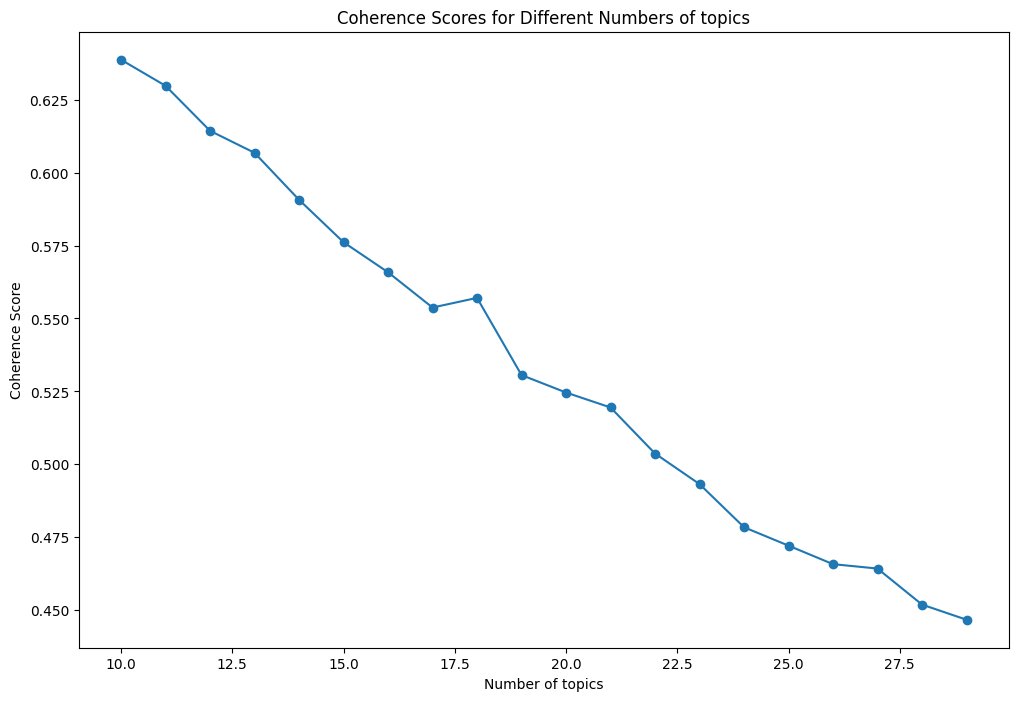

In [8]:
# Create a dictionary
id2word = corpora.Dictionary(all_bigrams)

# Filter out words that occur in less than 1 documents or more than 1% of the documents
id2word.filter_extremes(no_below=1, no_above=0.01)

# Create a corpus
corpus = [id2word.doc2bow(doc) for doc in all_bigrams]

# Set the number of runs to obtain an average coherence score
runs = 10

# Set the range of cluster numbers to evaluate
cluster_range = range(10, 30)

# Create list to store coherence score
coherence_scores = []

# Create list to store average coherence scores
avg_coherence_scores = []
models = []

# Calculate coherence scores for each cluster number
for num_clusters in cluster_range:
    random.seed(42)
    model_coherences = []
    for _ in range(runs):
        # Initialize the LDA model
        model = LdaModel(corpus=corpus, num_topics=num_clusters)

        # Calculate the coherence score
        coherencemodel = CoherenceModel(model=model, texts=all_bigrams, dictionary=id2word, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())

        # Calculate coherence per run
        model_coherences.append(coherencemodel.get_coherence())

    # Calculate average coherence
    avg_coherence = sum(model_coherences) / runs

    # Append average coherence to separate list
    avg_coherence_scores.append(avg_coherence)
    models.append(model)

# Print the average coherence score
print(avg_coherence_scores)

# Visualize the coherence scores in a plot
plt.figure(figsize=(12, 8))
plt.plot(cluster_range, avg_coherence_scores, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of topics")
plt.show()

##Grid research for the alpha and eta

In [10]:
# Define the alpha and eta values to evaluate
alpha_range = [0.01, 0.05, 0.1, 0.5, 1, 3.5]
eta_range = [0.01, 0.05, 0.1, 0.5, 1, 3.5]

best_coherence = -1.0
best_alpha = None
best_eta = None

# Iterate over all combinations of alpha and eta
for alpha in alpha_range:
    for eta in eta_range:
        model = LdaModel(corpus=corpus, num_topics=10, id2word=id2word, alpha=alpha, eta=eta)
        coherence_model = CoherenceModel(model=model, texts=all_bigrams, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        print("Alpha:", alpha, "Eta:", eta, "Coherence Score:", coherence_score)

        # Check if this is the best coherence score so far
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_alpha = alpha
            best_eta = eta

# Print the best coherence score and corresponding alpha and eta values
print("Best Coherence Score:", best_coherence)
print("Best Alpha:", best_alpha)
print("Best Eta:", best_eta)

Alpha: 0.01 Eta: 0.01 Coherence Score: 0.7323391982500431


Alpha: 0.01 Eta: 0.05 Coherence Score: 0.711741749650382


Alpha: 0.01 Eta: 0.1 Coherence Score: 0.7243408416079371


Alpha: 0.01 Eta: 0.5 Coherence Score: 0.6873069300731204


Alpha: 0.01 Eta: 1 Coherence Score: 0.7219755350716286


Alpha: 0.01 Eta: 3.5 Coherence Score: 0.7229903539900993


Alpha: 0.05 Eta: 0.01 Coherence Score: 0.6758596802024539


Alpha: 0.05 Eta: 0.05 Coherence Score: 0.6806876320496456


Alpha: 0.05 Eta: 0.1 Coherence Score: 0.6706707075834337


Alpha: 0.05 Eta: 0.5 Coherence Score: 0.6798648359174637


Alpha: 0.05 Eta: 1 Coherence Score: 0.6754782655075574


Alpha: 0.05 Eta: 3.5 Coherence Score: 0.6844982311383491


Alpha: 0.1 Eta: 0.01 Coherence Score: 0.6509528003770714


Alpha: 0.1 Eta: 0.05 Coherence Score: 0.6428696185294764


Alpha: 0.1 Eta: 0.1 Coherence Score: 0.6494434632312783


Alpha: 0.1 Eta: 0.5 Coherence Score: 0.63017929629816


Alpha: 0.1 Eta: 1 Coherence Score: 0.6418540000371833


Alpha: 0.1 Eta: 3.5 Coherence Score: 0.6161848066088652


Alpha: 0.5 Eta: 0.01 Coherence Score: 0.525156898684798


Alpha: 0.5 Eta: 0.05 Coherence Score: 0.529074871218364


Alpha: 0.5 Eta: 0.1 Coherence Score: 0.5039753597089593


Alpha: 0.5 Eta: 0.5 Coherence Score: 0.5084155610185782


Alpha: 0.5 Eta: 1 Coherence Score: 0.56216106922081


Alpha: 0.5 Eta: 3.5 Coherence Score: 0.6077833506621828


Alpha: 1 Eta: 0.01 Coherence Score: 0.7731306198435629


Alpha: 1 Eta: 0.05 Coherence Score: 0.7672085426113504


Alpha: 1 Eta: 0.1 Coherence Score: 0.7775159536366727


Alpha: 1 Eta: 0.5 Coherence Score: 0.7805424497401774


Alpha: 1 Eta: 1 Coherence Score: 0.7800028206571833


Alpha: 1 Eta: 3.5 Coherence Score: 0.7724194586167554


Alpha: 3.5 Eta: 0.01 Coherence Score: 0.7926239299095855


Alpha: 3.5 Eta: 0.05 Coherence Score: 0.7850388809049611


Alpha: 3.5 Eta: 0.1 Coherence Score: 0.7859487701516116


Alpha: 3.5 Eta: 0.5 Coherence Score: 0.7920820680355352


Alpha: 3.5 Eta: 1 Coherence Score: 0.7861848291150093
Alpha: 3.5 Eta: 3.5 Coherence Score: 0.7840918508351815
Best Coherence Score: 0.7926239299095855
Best Alpha: 3.5
Best Eta: 0.01


## LDA model with the optimal number of topics, alpha and eta

In [19]:
# Initialize the alpha and eta
alpha = 0.1
eta = 0.1

# Initialize the LDA model with specified parameters
model = LdaModel(corpus=corpus, num_topics=10,id2word=id2word, alpha=alpha, eta=eta)

# Calculate the coherence score of the model
coherence_model = CoherenceModel(model=model, texts=all_bigrams, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print the coherence score of the model
print("Coherence Score:", coherence_score)

Coherence Score: 0.6700616794448326


In [20]:
# Number op topic with the highest coherence value
N_TOPICS = 10

# Getting words with the highest probability for the each topic
for topic in range(N_TOPICS):
    words = model.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: dag_week werken_discipline mensen_plaats resultaten_projecten collega_werk werk_communicatie projecten_toekomst rendament_discipline informatie_onderdeeltje schip_beland
Topic 1: uur_week week_september sector_programma functies_sector programma_functies innovaties_projecten week_uur dag_week worklife_balance intranet_info
Topic 2: team_werk outside_plaats samenwerking_informatie kans_informatie kick_off communicatie_organisatie overleg_samenwerking werk_team werken_afdelingen casussen_focus
Topic 3: jaar_ervaring werken_dingen team_werk sector_afdeling mensen_organisatie huis_werken werk_organisatie financien_koers zaken_werkdruk functie_afdeling
Topic 4: contact_collega projecten_project team_samenwerking vragen_opmerkingen rol_teamleider collega_presteren warmte_airco dingen_tijd verhaal_vraag functie_categorieën
Topic 5: samenwerking_communicatie vragen_ruimte team_management kennis_delen management_team collegas_regios motivatie_werknemers rol_teamleider dag_week teamleid

In [21]:
# Print the words with probabilities for each topic
model.print_topics()

[(0,
  '0.002*"dag_week" + 0.002*"werken_discipline" + 0.002*"mensen_plaats" + 0.002*"resultaten_projecten" + 0.001*"collega_werk" + 0.001*"werk_communicatie" + 0.001*"projecten_toekomst" + 0.001*"rendament_discipline" + 0.001*"informatie_onderdeeltje" + 0.001*"schip_beland"'),
 (1,
  '0.002*"uur_week" + 0.002*"week_september" + 0.002*"sector_programma" + 0.002*"functies_sector" + 0.002*"programma_functies" + 0.002*"innovaties_projecten" + 0.002*"week_uur" + 0.002*"dag_week" + 0.002*"worklife_balance" + 0.002*"intranet_info"'),
 (2,
  '0.003*"team_werk" + 0.002*"outside_plaats" + 0.002*"samenwerking_informatie" + 0.002*"kans_informatie" + 0.002*"kick_off" + 0.002*"communicatie_organisatie" + 0.001*"overleg_samenwerking" + 0.001*"werk_team" + 0.001*"werken_afdelingen" + 0.001*"casussen_focus"'),
 (3,
  '0.002*"jaar_ervaring" + 0.002*"werken_dingen" + 0.002*"team_werk" + 0.002*"sector_afdeling" + 0.002*"mensen_organisatie" + 0.002*"huis_werken" + 0.001*"werk_organisatie" + 0.001*"financi